In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import datasets, transforms, models # --> new
from torchmetrics.functional import accuracy
# from pytorch_lightning.metrics.functional import accuracy
from torch.utils.data import DataLoader, random_split 
import skimage
import torchxrayvision as xrv

import requests
from PIL import Image

In [2]:
def tensor_to_imgnumpy(image: torch.Tensor, denormalize=False) -> np.ndarray:
    assert image.dim() == 3, f"expecting [3,256,256], the input size is {image.size()}" 
    
    imgnumpy = image.numpy().transpose(1,2,0)
    if denormalize:
        imgnumpy = imgnumpy*np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.22))
    
    imgnumpy = imgnumpy.clip(0, 1)
    return imgnumpy

In [28]:
from cifar10_models.inception import inception_v3
from cifar10_models.googlenet import googlenet
from cifar10_models.mobilenetv2 import mobilenet_v2
from cifar10_models.resnet import resnet18
xrv_densenet = xrv.models.DenseNet(weights="densenet121-res224-all")
modelUsed = xrv_densenet

print(modelUsed)

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O C:\Users\santo\.torchxrayvision\models_data\nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
XRV-DenseNet121-densenet121-res224-all


In [29]:
print(modelUsed)

XRV-DenseNet121-densenet121-res224-all


In [4]:
class CustomNormalize(torch.nn.Module):
    """Normalize a tensor image with mean and standard deviation.
    This transform does not support PIL Image.
    Given mean: ``(mean[1],...,mean[n])`` and std: ``(std[1],..,std[n])`` for ``n``
    channels, this transform will normalize each channel of the input
    ``torch.*Tensor`` i.e.,
    ``output[channel] = (input[channel] - mean[channel]) / std[channel]``
    .. note::
        This transform acts out of place, i.e., it does not mutate the input tensor.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation in-place.
    """

    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, img: np.ndarray) -> np.ndarray:
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        return (2 * (img.astype(np.float32) / 255) - 1.) * 1024

#     def __repr__(self) -> str:
#         return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

In [5]:
class ToNumpy(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, img):
        return np.array(img)

In [6]:
class AddColorChannel(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, img):
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")
        return img[None, :, :]

In [7]:
tf_tonumpy = ToNumpy()
tf_custom_normalize = CustomNormalize()
tf_add_color_channel = AddColorChannel()
tf_totensor = transforms.ToTensor()

In [23]:
tf_compose = transforms.Compose([
            tf_tonumpy,
            tf_custom_normalize,
            tf_add_color_channel,
#             xrv.datasets.XRayCenterCrop(),
            xrv.datasets.XRayResizer(224),
#             tf_totensor
])

In [24]:
dataset_test = datasets.ImageFolder(root='./data/Batch 1/dummy/', transform=tf_compose)

In [25]:
print(dataset_test)

Dataset ImageFolder
    Number of datapoints: 3
    Root location: ./data/Batch 1/dummy/
    StandardTransform
Transform: Compose(
               ToNumpy()
               CustomNormalize()
               AddColorChannel()
           )


In [26]:
def tensor_to_imgnumpy_simple(image):
    imgnumpy = image
    imgnumpy = imgnumpy.squeeze()
    return imgnumpy

torch.Size([1, 1, 224, 224])
<class 'torch.Tensor'>
torch.Size([1, 1, 224, 224])
<class 'torch.Tensor'>
torch.Size([1, 1, 224, 224])
<class 'torch.Tensor'>


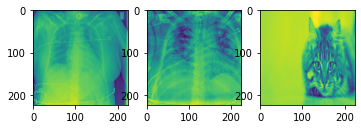

In [27]:
def imshow(imgnumpy: np.ndarray):
    plt.imshow(tensor_to_imgnumpy_simple(imgnumpy))

loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

# for img, y in loader:
#     print(type(img[0]))
#     converted_img = tensor_to_imgnumpy_simple(img[0])
#     type(converted_img)
#     plt.imshow(img.squeeze())
    
plt.figure(figsize=(20, 8))
for idx,(img) in enumerate(loader):
    plt.subplot(4,10,idx+1)
    imshow(img[0])
    print(img[0].shape)
    print(type(img[0]))
        
# plt.tight_layout()

In [22]:
class FinetunedModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # load pretrained model
        model = resnet18(pretrained=True)
        
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

        self.avgpool = model.avgpool
        
        self.fc = model.fc
        
#         freeze the feature learning
#         for param in self.conv1.parameters():
#               param.requires_grad = False
        
#         for param in self.bn1.parameters():
#               param.requires_grad = False
                
#         for param in self.relu.parameters():
#               param.requires_grad = False
                
#         for param in self.maxpool.parameters():
#               param.requires_grad = False
                
#         for param in self.layer1.parameters():
#               param.requires_grad = False
        
#         for param in self.layer2.parameters():
#               param.requires_grad = False
                
#         for param in self.layer3.parameters():
#               param.requires_grad = False
                
#         for param in self.layer4.parameters():
#               param.requires_grad = False
        
        # change the number of output classes of the last layer
        # this is useless line as it the number of output classes is already set to be 10
        self.fc = nn.Linear(
            in_features=self.fc.in_features,
            out_features=2)
        
        # follow https://pytorch.org/hub/pytorch_vision_alexnet/
        tf_tonumpy = ToNumpy()
        tf_custom_normalize = CustomNormalize()
        tf_totensor = transforms.ToTensor()
        self.tf_compose = transforms.Compose([
            tf_tonumpy,
            tf_custom_normalize,
            xrv.datasets.XRayCenterCrop(),
            xrv.datasets.XRayResizer(224),
            tf_totensor
        ])
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x
    
    def training_step(self, batch, batch_idx):
        # Copy paste from the previous article
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels) # --> NEW. Using nn.CrossEntropyLoss
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # This is new, but the structure is the same as training_step
        inputs, labels = batch
        
        outputs = self.forward(inputs)
#         import pdb; pdb.set_trace()
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels) # --> NEW
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # This is new, but the structure is the same as test_step
        # but I replace val_loss --> test_loss etc
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def setup(self, stage=None):
        # split, transform, secretly move to GPU (if needed) by PL (not by us)
        if stage == 'fit' or stage is None:
            dataset_full = datasets.ImageFolder(root='./data/Batch 1/Train/', transform=self.tf_compose)
            
            # split
            SIZE_TRAIN_DATA = int(len(dataset_full)*0.75)
            SIZE_VAL_DATA = len(dataset_full)-SIZE_TRAIN_DATA
            self.dataset_train, self.dataset_val = random_split(dataset_full, [SIZE_TRAIN_DATA,SIZE_VAL_DATA])
            
        if stage == 'test' or stage is None:
            self.dataset_test = datasets.ImageFolder(root='./data//Batch 1/Test/', transform=self.tf_compose)
            
#         import pdb; pdb.set_trace()
            
    def train_dataloader(self): 
        return DataLoader(self.dataset_train, batch_size=50, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=50, num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=50, num_workers=2)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3276778918.py, line 61)

In [5]:
pl.seed_everything(88) # --> for consistency, change the number with your favorite number :D

model = FinetunedModel()

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
try:
    trainer = pl.Trainer(gpus=1,max_epochs=100,default_root_dir='./custom_logs')
except Exception as e:
    # most likely due to GPU, so fallback to non GPU
    print(e)
    trainer = pl.Trainer(max_epochs=100,default_root_dir='./custom_logs')

trainer.fit(model)

Global seed set to 88
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | conv1   | Conv2d            | 1.7 K 
1 | bn1     | BatchNorm2d       | 128   
2 | relu    | ReLU              | 0     
3 | maxpool | MaxPool2d         | 0     
4 | layer1  | Sequential        | 147 K 
5 | layer2  | Sequential        | 525 K 
6 | layer3  | Sequential        | 2.1 M 
7 | layer4  | Sequential        | 8.4 M 
8 | avgpool | AdaptiveAvgPool2d | 0     
9 | fc      | Linear            | 1.0 K 
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.679    Total estimated model params size (MB)


GPUAccelerator can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\santo\.conda\envs\py3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\santo\.conda\envs\py3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_sta

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [6]:
trainer.test()

C:\Users\santo\.conda\envs\py3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at custom_logs\lightning_logs\version_2\checkpoints\epoch=99-step=1100.ckpt
Loaded model weights from checkpoint at custom_logs\lightning_logs\version_2\checkpoints\epoch=99-step=1100.ckpt
C:\Users\santo\.conda\envs\py3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to im

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7745664715766907
        test_loss           1.2678954601287842
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.2678954601287842, 'test_acc': 0.7745664715766907}]

Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
Torch not compiled with CUDA enabled
T

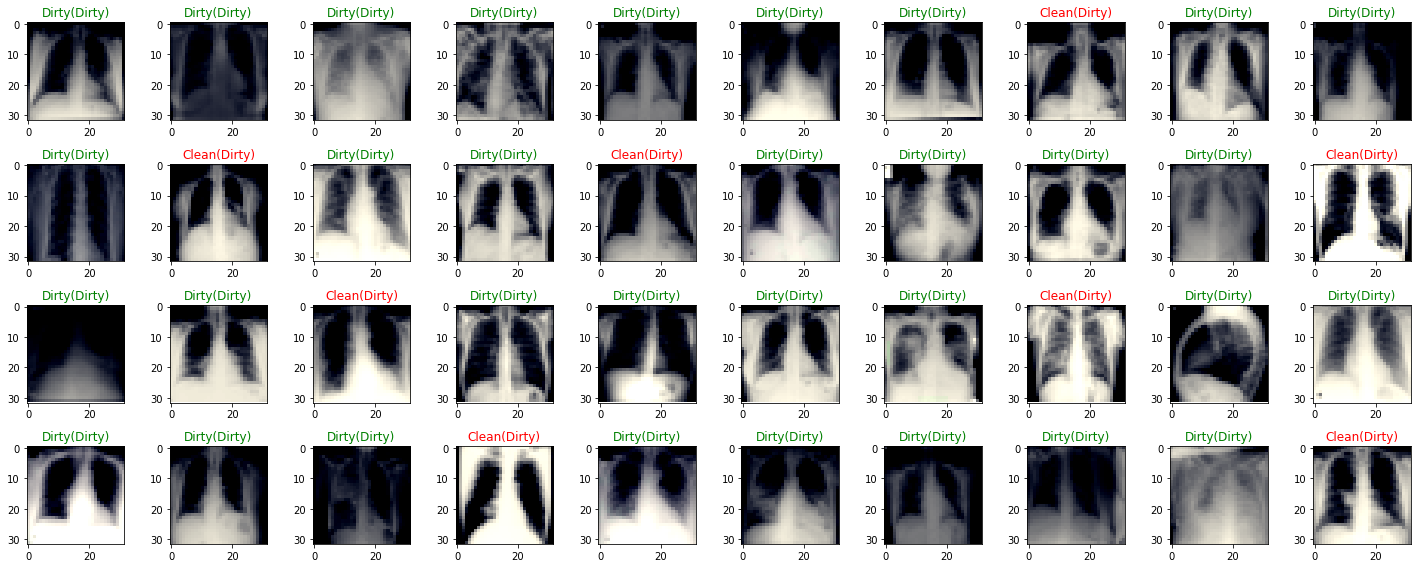

In [7]:
dataset_classes = ['Clean','Dirty']

def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy(imgnumpy,denormalize=denormalize))
    plt.title(dataset_classes[label])
    
loader = DataLoader(model.dataset_test, batch_size=1, shuffle=True)

plt.figure(figsize=(20, 8))
for idx,(img,label) in enumerate(loader):
    plt.subplot(4,10,idx+1)
    imshow(img[0],label,denormalize=True)
    
    # inference
    try:
        pred = model.forward(img.cuda())
    except Exception as e:
        pred =  model.forward(img)
        print(e)

    title_dataset = dataset_classes[label]
    title_pred = dataset_classes[pred.argmax()]
    plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"))
    
    if idx == 40-1:
        break
        
plt.tight_layout()

In [30]:
%reload_ext tensorboard
%tensorboard --logdir custom_logs/ --port=6007